In [1]:
input_file = '../../1_AssembledAdata.h5ad'

### 10x genomics 플랫폼의 종류

| | **Chromium Single Cell** | **Visium Spatial** | **Xenium In Situ** |
| :--- | :--- | :--- | :--- |
| **Platform** | Chromium | Visium| Xenium|
| **When to use** | **종합적인 단일 세포 데이터**<br>세포 집단과 상태에 대한 심층 분석에 이상적 | **고해상도 공간 유전자 발현**<br>복잡한 조직, 이웃 세포, 세포 간 상호작용 이해.<br>다른 공간 오믹스, 조직학, 형태학과 통합. | Visium 과 동일 |
| **Why to use** | 편향 없는 단일 세포 발견,<br>유전자별 높은 민감도 | 편향 없는 공간적 발견 | 표적 기반 공간 탐색,<br>유전자별 높은 민감도 |
| **Applications** | 전체 전사체 유전자 발현<br>단백질<br>TCR, BCR<br>CRISPR<br>ATAC | 전체 전사체 유전자 발현 | 표적 유전자 발현 (최대 5,000개 유전자) |
| **Resolution** | 단일 세포 (Single cell) | 2-µm 영역에 할당된 전사체 | 단일 세포 (Single cell) |
| **Data readout** | Sequencing 기반 | Sequencing 기반 | Image 기반 |
| **Sample compatibility**| Single cell or nuclei suspensions from fresh, frozen, or FFPE samples | FFPE<br>Fresh frozen<br>Fixed frozen | Fresh frozen<br>FFPE |

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#ultils
#import ipynbname
from datetime import datetime

In [3]:
# Custom functions
sys.path.append('HelperFunctions')
import Day1Helper as fn

In [4]:
#Cell filtering   
MIN_GENES = 850
MAX_GENES = 10000

MIN_COUNTS = 1500
MAX_COUNTS = 15000

PCT_MITO = 10
PCT_RIBO = 25

#Gene Filtering
PCT_CELLS = 0.25

**미토콘드리아 비율을 확인하는 이유**
> "A high fraction of mitochondrial counts can be indicative of cells with broken membranes. In such cases, the cytoplasmic mRNA has leaked out, leaving behind the more conserved mRNA located in the mitochondria."    
>
> _높은 비율의 미토콘드리아 유전자 발현량은 세포막이 손상된 세포를 나타내는 지표가 될 수 있습니다. 이러한 경우, 세포질의 mRNA는 밖으로 유출되고 미토콘드리아 내의 보존되어있는 mRNA만 남게 됩니다._
>
>_Current best practices in single‐cell RNA‐seq analysis: a tutorial (2019)_

    

**리보솜 유전자 비율을 확인하는 이유**
>"A large number of studies have shown that ribosomal protein-coding genes (RPGs) are highly expressed and co-expressed in many cell types. [...]    
>the expression of RPGs is often correlated with the cell cycle, and in some studies, RPGs are removed before downstream analysis. [...]    
>However, the expression of RPGs can also reflect the metabolic activity of cells, and their expression levels are different in different cell types."
>
>_많은 연구에서 리보솜 단백질 암호화 유전자(RPG)가 다양한 세포 유형에서 높게 발현되고 함께 발현된다는 것을 보여주었습니다. [...]    
>RPG의 발현은 종종 **세포 주기**와 연관되어 있으며, 일부 연구에서는 다음 분석 단계 전에 **RPG를 제거**하기도 합니다. [...]    
>하지만, RPG의 발현은 세포의 대사 활동을 반영할 수도 있으며, 그 발현 수준은 다른 세포 유형에서 다르게 나타납니다._
>
>_Effective ribosomal RNA depletion for single-cell total RNA-seq by scDASH (2021)_

In [5]:
# batch key for calculation of HVG and for Harmony correction 
BATCH_KEY = 'batch_key'

In [6]:
# Number of Principal component for UMAP
N_PCs = 18

#PCA 분석 -> 차원축소 이후 상위 18개의 주성분만 UMAP 계산에 사용

In [7]:
# Leiden resolution chosen for clusters
chosen_leiden = 'Leiden_04'

#세포 군집을 위해 사용하는 Leiden 알고리즘을 해상도 0.4로 실행

### Anndata에 대하여
<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="400">    

scRNA-seq 데이터를 다루기 위해 만들어진 데이터 구조    
* adata.X: 핵심 데이터셋. 행은 세포, 열은 유전자. 희소행렬/밀집행렬을 이용한 메모리효율적 구조로 이루어짐.
* adata.obs: 세포에 대한 메타데이터. 각 행은 adata.X의 행과 같음. Sequencing에 따른 세포유형, 실험배치, QC matrics 등을 가짐
* adata.var: 유전자에 대한 메타데이터. 각 행은 adata.X의 열과 같음. 유전자 ID 등을 가짐
* adata.obsm: 세포에 대한 다차원 데이터.
* adata.varm: 유전자에 대한 다차원 데이터.
* adata.obsp: 세포-세포 사이의 관계를 나타내는 그래프 데이터.
* adata.varp: 유전자-유전사 사이의 관계를 나타내는 그래프 데이터.
* adata.layers: adata.X에 담지 못한 추가 데이터
* adata.uns: 비정형 데이터셋

### Read adata

In [8]:
adata = sc.read(input_file)
adata

AnnData object with n_obs × n_vars = 57868 × 33355
    obs: 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'Auth_seurat_clusters', 'Auth_RNA.Counts', 'Auth_RNA.Features', 'Auth_Percent.MT', 'Auth_Percent.Ribo', 'Auth_Cell.Barcode', 'Auth_DF_pANN', 'Auth_DF_classification', 'Auth_DF_pANN_quantile', 'Auth_Spliced.Counts', 'Auth_Spliced.Features', 'Auth_Unspliced.Counts', 'Auth_Unspliced.Features', 'Auth_Ambiguous.Counts', 'Auth_Ambiguous.Features', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'cell_label'
    var: 'start_position', 'end_position', 'chromosome_name', 'ensg'

### Barcode metadata
* Barcode = 각 세포들에게 부여된 ID

In [9]:
barcodes = adata.obs
barcodes

,Auth_Sample.ID,Auth_Age,Auth_Tissue.ID,Auth_Sample.Type,Auth_Assay,Auth_Batch,Auth_seurat_clusters,Auth_RNA.Counts,Auth_RNA.Features,Auth_Percent.MT,...,Auth_Unspliced.Features,Auth_Ambiguous.Counts,Auth_Ambiguous.Features,dataset_id,sample_id,brain_region,age,stage,batch_key,cell_label
hft_w20_p3_r1_AAACCCAAGCTGCGAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c16,1397,677,0.070866,...,54,94,69,Id0003,hft_w20_p3_r1,cerebral_cortex,PCW_20,prenatal,b2019_06_RNAv3,Microglia
hft_w20_p3_r1_AAACCCAAGGTAGTAT,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c11,14338,4301,0.053200,...,2526,1431,669,Id0003,hft_w20_p3_r1,cerebral_cortex,PCW_20,prenatal,b2019_06_RNAv3,GliaPg
hft_w20_p3_r1_AAACCCACAACTCCAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c17,9260,3481,0.043511,...,2515,1095,669,Id0003,hft_w20_p3_r1,cerebral_cortex,PCW_20,prenatal,b2019_06_RNAv3,OPC_Oligo
hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c0,4025,1969,0.015396,...,2058,634,377,Id0003,hft_w20_p3_r1,cerebral_cortex,PCW_20,prenatal,b2019_06_RNAv3,ExN_N5
hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c4,7131,2930,0.044690,...,2106,909,556,Id0003,hft_w20_p3_r1,cerebral_cortex,PCW_20,prenatal,b2019_06_RNAv3,ExN_N4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c6,8532,3497,0.018749,...,2059,973,612,Id0003,hft_w16_p7_r2,cerebral_cortex,PCW_16,prenatal,b2020_03_RNANG,RG_early
hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,6689,2393,0.045577,...,1362,677,396,Id0003,hft_w16_p7_r2,cerebral_cortex,PCW_16,prenatal,b2020_03_RNANG,ExN_N1
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,3865,1799,0.035954,...,832,431,273,Id0003,hft_w16_p7_r2,cerebral_cortex,PCW_16,prenatal,b2020_03_RNANG,ExN_N1
hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,5293,2365,0.032861,...,2211,672,416,Id0003,hft_w16_p7_r2,cerebral_cortex,PCW_16,prenatal,b2020_03_RNANG,ExN_N1


In [10]:
#바코드 수 확인
adata.n_obs

57868

In [11]:
# 바코드 메타데이터의 feature 확인
adata.obs.columns

Index(['Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type',
       'Auth_Assay', 'Auth_Batch', 'Auth_seurat_clusters', 'Auth_RNA.Counts',
       'Auth_RNA.Features', 'Auth_Percent.MT', 'Auth_Percent.Ribo',
       'Auth_Cell.Barcode', 'Auth_DF_pANN', 'Auth_DF_classification',
       'Auth_DF_pANN_quantile', 'Auth_Spliced.Counts', 'Auth_Spliced.Features',
       'Auth_Unspliced.Counts', 'Auth_Unspliced.Features',
       'Auth_Ambiguous.Counts', 'Auth_Ambiguous.Features', 'dataset_id',
       'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'cell_label'],
      dtype='object')

<Axes: xlabel='sample_id'>

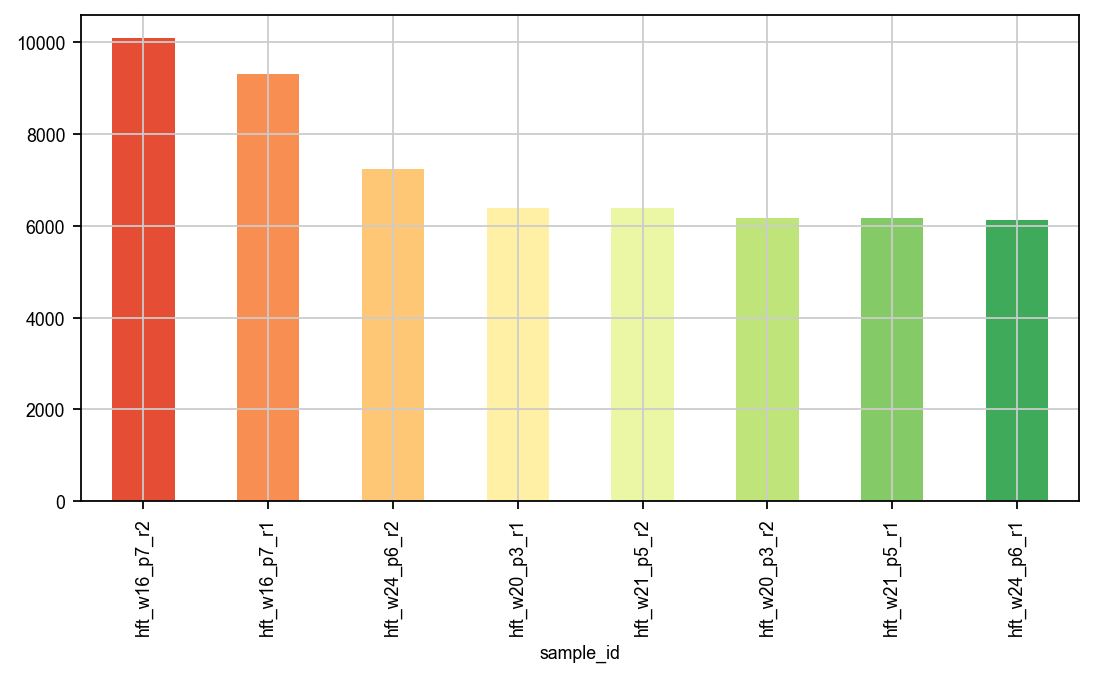

In [12]:
#바코드 'sample_id' 시각화
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['sample_id'].value_counts())))

adata.obs['sample_id'].value_counts().plot.bar(color=category_colors)

In [13]:
# 바코드 메타데이터의 cell_label feature 확인
adata.obs['cell_label'].unique()

['Microglia', 'GliaPg', 'OPC_Oligo', 'ExN_N5', 'ExN_N4', ..., 'ExN_N1', 'ExN_N6', 'ExN_N8', 'RBC', 'VLMC']
Length: 23
Categories (23, object): ['CycProg', 'Endo', 'ExN_N1', 'ExN_N2', ..., 'RG_late', 'SubPlate', 'VLMC', 'tRG']

<Axes: xlabel='cell_label'>

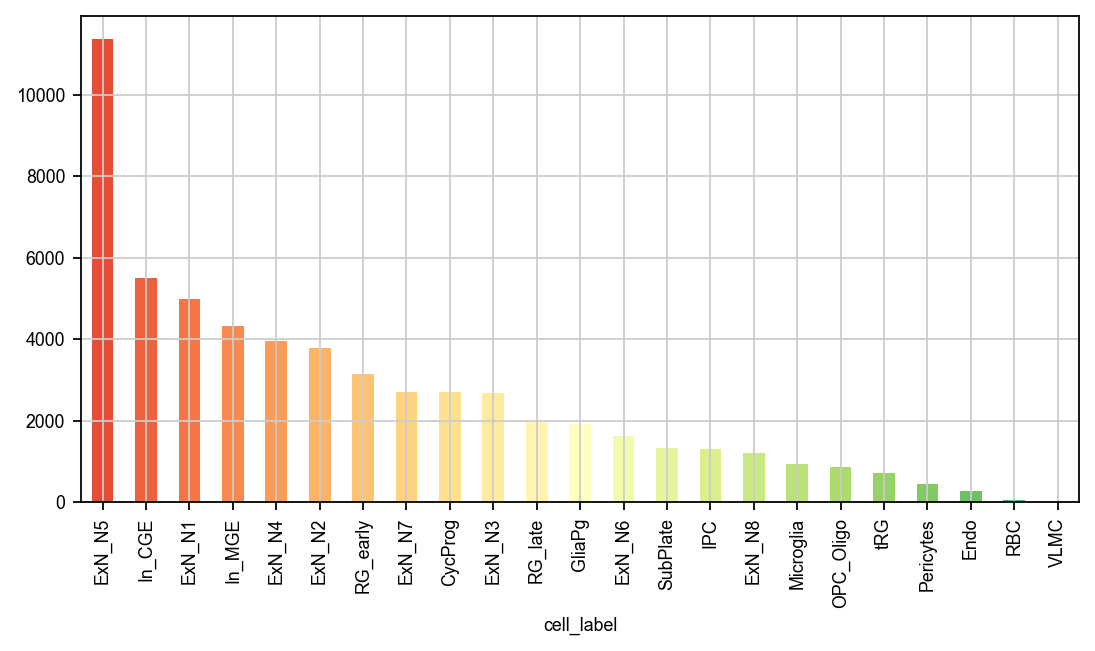

In [14]:
# 바코드 메타데이터의 cell_label 시각화
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['cell_label'].value_counts())))

adata.obs['cell_label'].value_counts().plot.bar(color=category_colors)

In [15]:
# 바코드의 메타데이터에서 cell_label 차원을 축소한 cell_class라는 새로운 feature를 만들어보자
Dict = {'ExN_N5': 'ExN', 'In_CGE': 'InN', 'ExN_N1': 'ExN',
        'In_MGE': 'InN', 'ExN_N4': 'ExN', 'ExN_N2': 'ExN', 
        'RG_early': 'Pg', 'ExN_N7': 'ExN', 'CycProg': 'Pg', 
        'ExN_N3': 'ExN', 'RG_late': 'Pg', 'GliaPg': 'Pg', 
        'ExN_N6': 'ExN', 'SubPlate': 'ExN', 'IPC': 'IPC', 
        'ExN_N8': 'ExN', 'Microglia': 'Microglia', 'OPC_Oligo': 'OPC_Oligo', 
        'tRG': 'Pg', 'Pericytes': 'Other', 'Endo': 'Other',
        'RBC': 'Other', 'VLMC': 'Other'
       }

adata.obs['cell_class'] = adata.obs['cell_label'].replace(Dict)

/var/folders/c5/7n1ywn_x79v664c15cr0h_0m0000gp/T/ipykernel_67973/85219887.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_class'] = adata.obs['cell_label'].replace(Dict)


<Axes: xlabel='cell_class'>

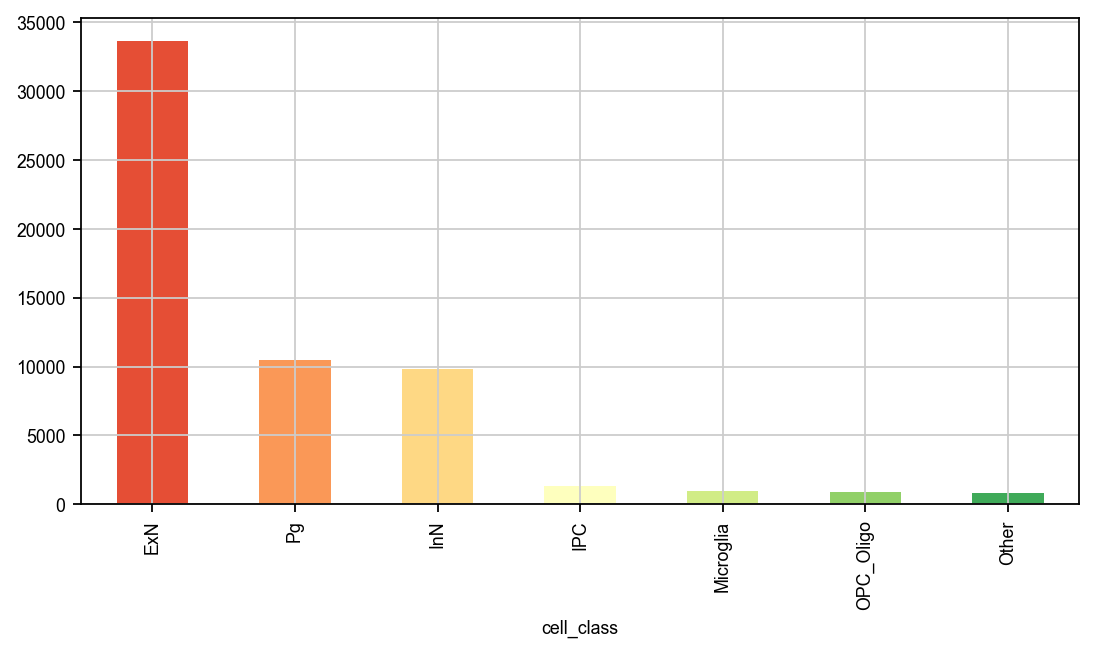

In [16]:
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['cell_class'].value_counts())))

adata.obs['cell_class'].value_counts().plot.bar(color=category_colors)

### Gene metadata

In [17]:
genes = adata.var
genes

,start_position,end_position,chromosome_name,ensg
external_gene_name,,,,
MIR1302-2HG,28589.0,31109.0,1,ENSG00000243485
FAM138A,34553.0,37595.0,1,ENSG00000237613
OR4F5,65419.0,71585.0,1,ENSG00000186092
ENSG00000238009,NaN,NaN,NaN,ENSG00000238009
ENSG00000239945,89551.0,91105.0,1,ENSG00000239945
...,...,...,...,...
MT-ND4L,10470.0,10766.0,MT,ENSG00000212907
MT-ND4,10760.0,12137.0,MT,ENSG00000198886
MT-ND5,12337.0,14148.0,MT,ENSG00000198786


In [18]:
#유전자 수 확인
adata.n_vars

33355

In [19]:
#유전자 메타데이터의 feature 확인
adata.var.columns

Index(['start_position', 'end_position', 'chromosome_name', 'ensg'], dtype='object')

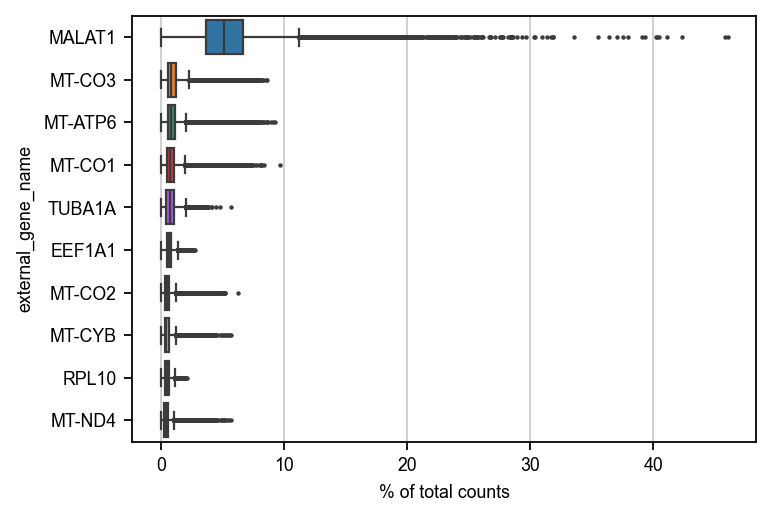

In [20]:
#Scanpy를 이용하여 '발현량이 높은 유전자들을' 확인
sc.pl.highest_expr_genes(adata, n_top=10)

### QC의 일환으로 미토콘드리아, 리보솜 유전자 비율 feature를 바코드(obs) 메타데이터 feature에 추가

In [21]:
#Find mito and ribo genes
mito_genes = adata.var_names.str.startswith('MT-')   
ribo_genes = adata.var_names.str.contains('^RPS|^RPL')

#qc_vars wants a column of adata.var containing T/F or 1/0 indicating the genes to be selected for sub-statistics
adata.var['mito'] = adata.var_names.str.startswith('MT-')    
adata.var['ribo']= adata.var_names.str.contains('^RPS|^RPL')

#Compute metrics (inplace=True to append to adata)
sc.pp.calculate_qc_metrics(adata, log1p=True, qc_vars=['mito','ribo'], inplace=True, percent_top=None)

In [22]:
adata.obs["gene_UMI_ratio"] = adata.obs["n_genes_by_counts"] / adata.obs["total_counts"]
adata.obs["log1p_gene_UMI_ratio"] = np.log1p(adata.obs["gene_UMI_ratio"])

In [24]:
adata.obs

,Auth_Sample.ID,Auth_Age,Auth_Tissue.ID,Auth_Sample.Type,Auth_Assay,Auth_Batch,Auth_seurat_clusters,Auth_RNA.Counts,Auth_RNA.Features,Auth_Percent.MT,...,total_counts,log1p_total_counts,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,gene_UMI_ratio,log1p_gene_UMI_ratio
hft_w20_p3_r1_AAACCCAAGCTGCGAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c16,1397,677,0.070866,...,1397,7.242798,99,4.605170,7.086614,380,5.942799,27.201145,0.484610,0.395152
hft_w20_p3_r1_AAACCCAAGGTAGTAT,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c11,14338,4301,0.053200,...,14338,9.570738,763,6.638568,5.321523,2572,7.852828,17.938346,0.299972,0.262343
hft_w20_p3_r1_AAACCCACAACTCCAA,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c17,9260,3481,0.043511,...,9260,9.133567,403,6.001415,4.352052,1891,7.545390,20.421166,0.375918,0.319121
hft_w20_p3_r1_AAACCCACATAGTCAC,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c0,4025,1969,0.015396,...,4025,8.300529,62,4.143135,1.540373,552,6.315358,13.714286,0.489193,0.398234
hft_w20_p3_r1_AAACCCAGTACAGGTG,hft_w20_p3_r1,pcw20,HFT3,HFT,RNA v3,b2019_06,c4,7131,2930,0.044690,...,7131,8.872347,319,5.768321,4.473426,1006,6.914731,14.107418,0.410882,0.344215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c6,8532,3497,0.018749,...,8532,9.051696,160,5.081404,1.875293,1164,7.060476,13.642757,0.409869,0.343497
hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,6689,2393,0.045577,...,6689,8.808369,305,5.723585,4.559725,1652,7.410347,24.697264,0.357752,0.305830
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,3865,1799,0.035954,...,3865,8.259976,139,4.941642,3.596378,615,6.423247,15.912031,0.465459,0.382169
hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2,pcw16,HFT7,HFT,RNA NG,b2020_03,c2,5293,2365,0.032861,...,5293,8.574329,174,5.164786,3.287361,837,6.731018,15.813338,0.446817,0.369366


## QC
* 다음의 feature들을 확인하고 기준을 만족하지 못하는 바코드 데이터는 삭제한다.
    * 미토콘드리아 유전자 수: 높으면 삭제
    * 리보솜 유전자 수: 높으면 삭제
    * `n_genes_by_counts`: 한 바코드(세포) 내에 존재하는 모든 유전자의 '종류'
    * `Total_counts`: 한 바코드(세포) 내에 존재하는 모든 유전자의 '수'

In [33]:
#바코드 중에서 'sample_id'를 확인하면 데이터의 총 샘플의 수를 알 수 있다.
adata.obs['sample_id'].unique().to_list()

#4명에서 각각 read1, read2가 생성되었다.

/var/folders/c5/7n1ywn_x79v664c15cr0h_0m0000gp/T/ipykernel_67973/582929284.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  adata.obs['sample_id'].unique().to_list()


['hft_w20_p3_r1',
 'hft_w20_p3_r2',
 'hft_w21_p5_r1',
 'hft_w21_p5_r2',
 'hft_w24_p6_r1',
 'hft_w24_p6_r2',
 'hft_w16_p7_r1',
 'hft_w16_p7_r2']

### 10x Genomics의 Single Cell 3' v2 라이브러리 시퀀싱에서 Read 1과 Read 2의 역할
* Read 1: 어떤 세포에서 유래한 RNA인지 식별하는 UMI 바코드 정보
* Read 2: 실제 유전자 서열(cDNA) 정보

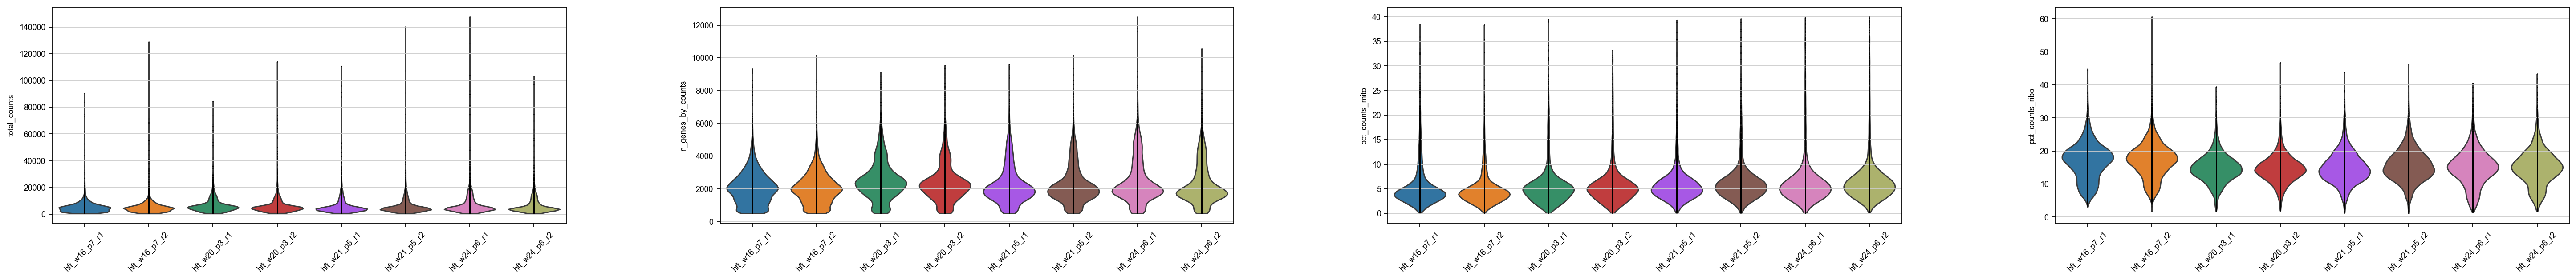

In [ ]:
sc.pl.violin(
    adata,
    keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
    groupby='sample_id',
    jitter=False,
    multi_panel=True,
    rotation=45
    )

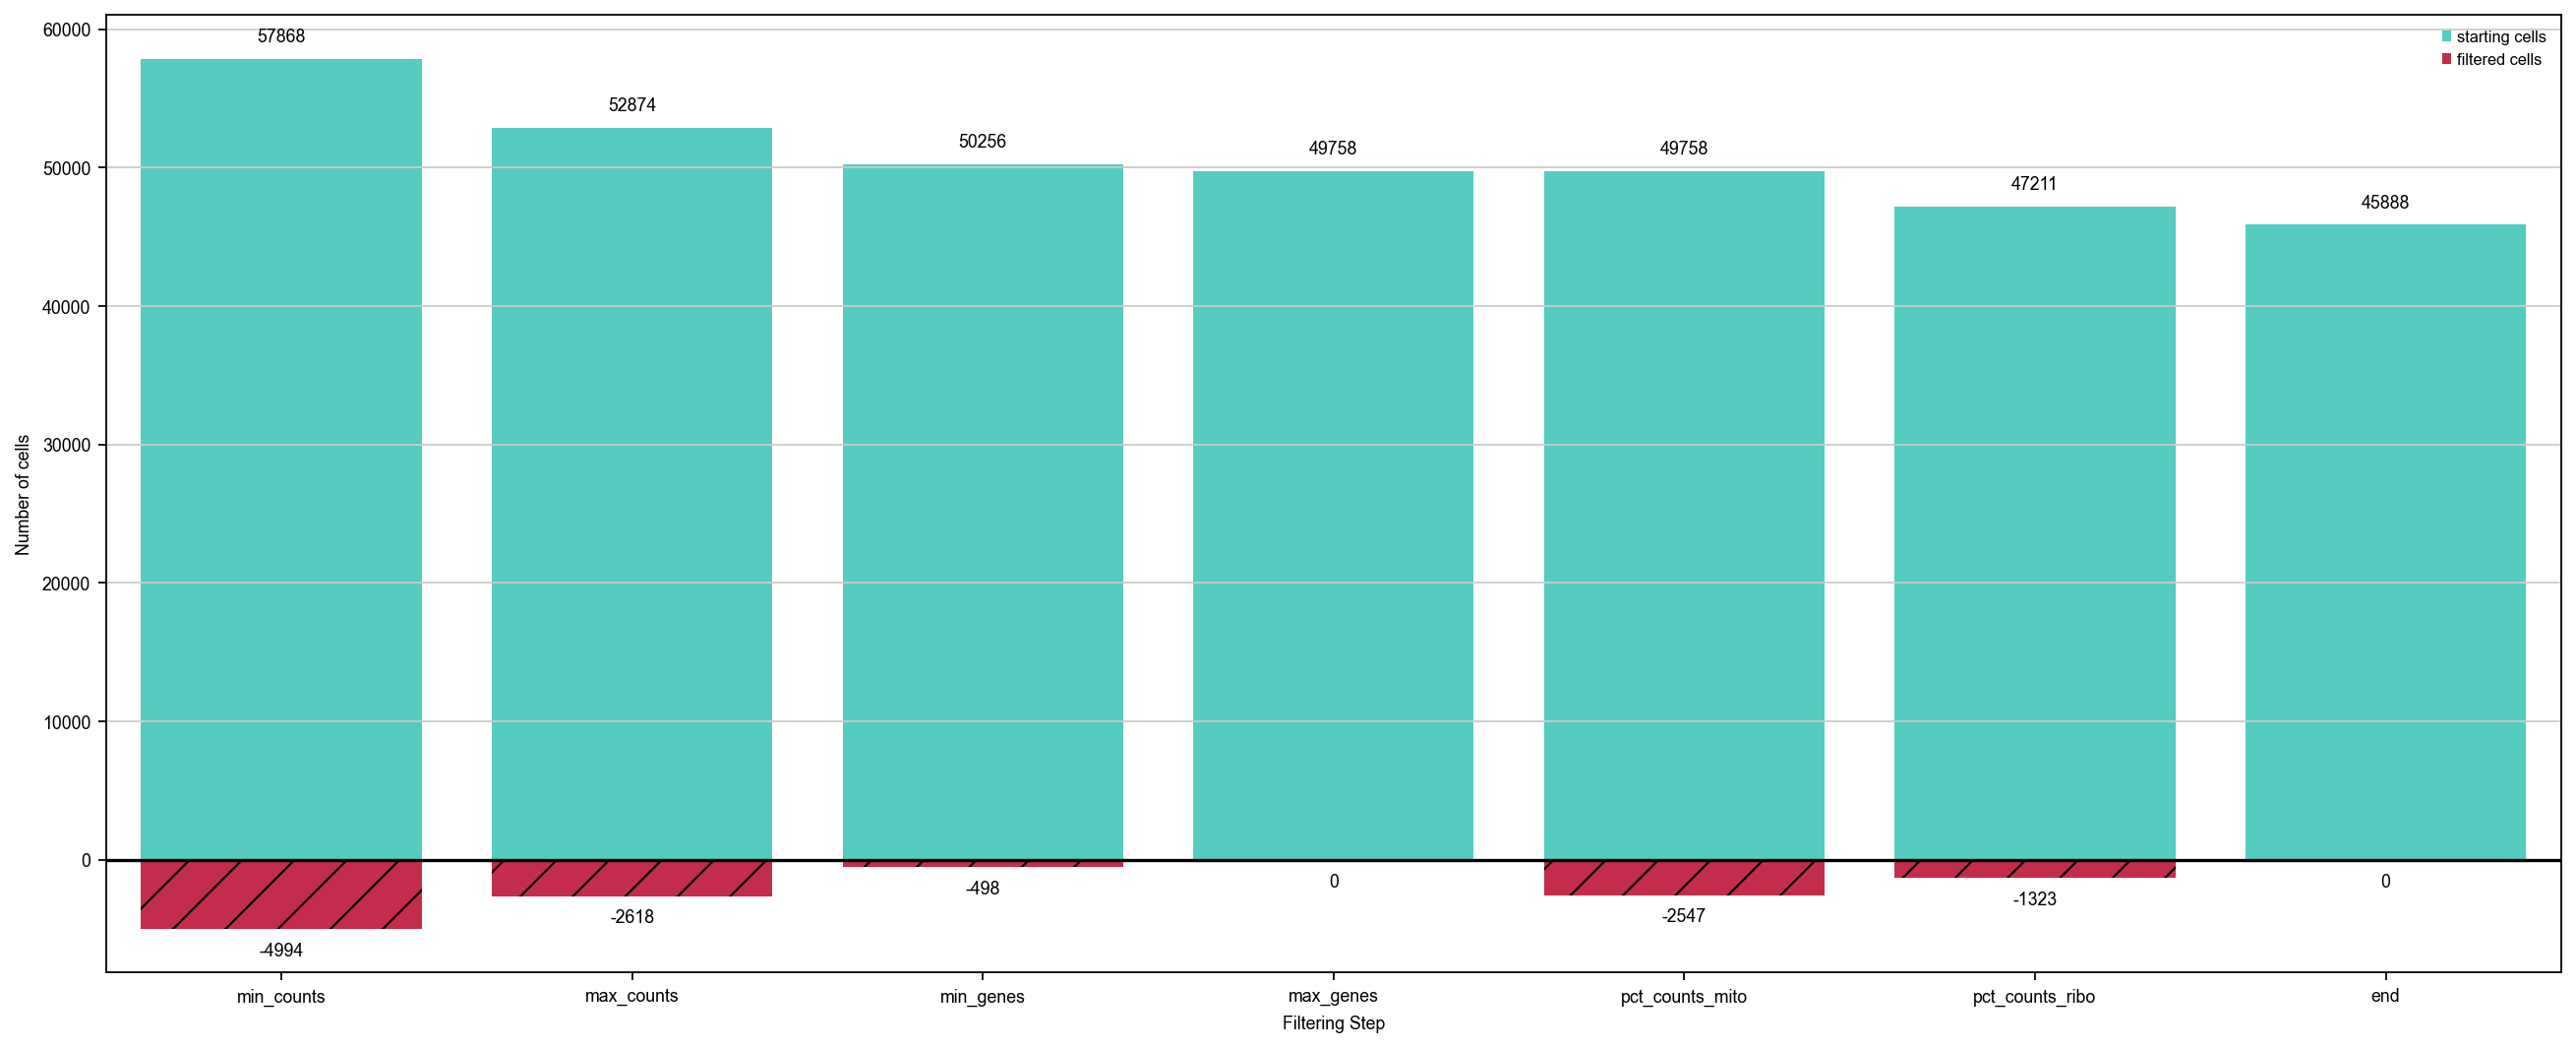

In [34]:
# QC 수행 및 시각화
fn.filterCellBarplot(adataObj=adata,
                     min_counts=MIN_COUNTS, max_counts=MAX_COUNTS,
                     min_genes=MIN_GENES, max_genes=MAX_GENES,
                     pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)